In [171]:
from elasticsearch import Elasticsearch
from elasticsearch.helpers import scan
from time import time
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import json

import matplotlib.pyplot as plt

from scipy.interpolate import interp1d

In [172]:
credentials = ('sushant', 'Mross@fmaB')
es = Elasticsearch(['atlas-kibana.mwt2.org:9200'], timeout=15, http_auth=credentials)
es.ping()

True

`June 18, 2019`

In [71]:
agg_my_query = {
"size": 0,
"query": {
   "bool": {
   "must": [
       {"term":{"src_VO":"ATLAS"}},
       {"term":{"dest_VO":"ATLAS"}},
       {
         "range":{
           "delay_mean": {
             "gte": 0
           }
         }
       },
       {
       "range": {
           "timestamp": {
           "gte": 1560891124000,
           "lte": 1560891125000,
           "format": "epoch_millis"
           }
       }
       }
   ]
   }
},
"aggs": {
   "2": {
   "terms": {
       "field": "src_site",
       "size": 999,
       "order": {
       "_key": "desc"
       }
   },
   "aggs": {
       "3": {
       "terms": {
           "field": "dest_site",
           "size": 999,
           "order": {
           "_key": "desc"
           }
       },
       "aggs": {
           "1": {
           "avg": {
               "field": "delay_mean"
           }
           }
       }
       }
   }
   }
}
}



In [72]:
my_query = {
    "size":1,
    "_source":["src","dest","timestamp"],
    "sort":[{"timestamp":"asc"}]
}

In [73]:
scroll = scan(client=es, index='ps_trace', query=my_query)
# agg_scroll = es.search(index='ps_owd',body = agg_my_query)

`June 19, 2019`

In [74]:
def getUniqueCount(es, index, field):
    '''
    Get Unique Count returns the distinct count of the field in the index.
    Field : Attribute In the Index (String)
    Index: Index in which we want ot search the field.
    '''
    query = {
    'aggs':{
        'uniq_val':{
            'cardinality':{
                'field':field,
                }
            }
        }    
    }
    try:
        result = es.search(index='ps_trace', body=query)
        val = result['aggregations']['uniq_val']['value']
        return val
    except Exception as e:
        print(e)
        return None

In [77]:
countOf = ['dest_host', 'dest', 'src_host', 'src', 'hash']
for i in countOf:
    print(i," : ", getUniqueCount(es,'ps_trace',i))

dest_host  :  808
dest  :  932
src_host  :  486
src  :  552
hash  :  4182939


`June 20, 2019`

In [78]:
def getUniqueHashBy(es, index, field):
    '''
    Get Unique Count returns the distinct count of the for each value of field in the index.
    Field : Attribute In the Index (String)
    Index: Index in which we want ot search the field.
    '''
    sz = getUniqueCount(es,index, field)
    print("Size : {}".format(sz))
    
    query = {
        "size":0,
        "aggs":{
            "FieldCounts":{
                "terms":{
                    "field":field,
                    "size":sz
                }
            }
        }
    }
    
    try:
        result = es.search(index=index, body=query)
        val = result['aggregations']['FieldCounts']['buckets']
        return val
    except Exception as e:
        print(e)
        return None

In [80]:
countOfBy = ['dest_host', 'dest', 'src_host', 'src']
for i in countOfBy:
    (i," : ", getUniqueHashBy(es,'ps_trace',i))

Size : 808
Size : 932
Size : 486
Size : 552


In [81]:
src_data = getUniqueHashBy(es,'ps_trace','src_host')
dest_data = getUniqueHashBy(es,'ps_trace','dest_host')

Size : 486
Size : 808


In [82]:
n = 100

def plotByHist(data, n):
    cdata = {}
    for result in data:
        cdata[result['key']] = result['doc_count']
    
    labels = list(cdata.keys())
    values = list(cdata.values())
    plt.figure(figsize=(16,9), dpi=512)
    plt.bar(labels[:n], values[:n])
    plt.xticks(rotation=90,fontsize=6)

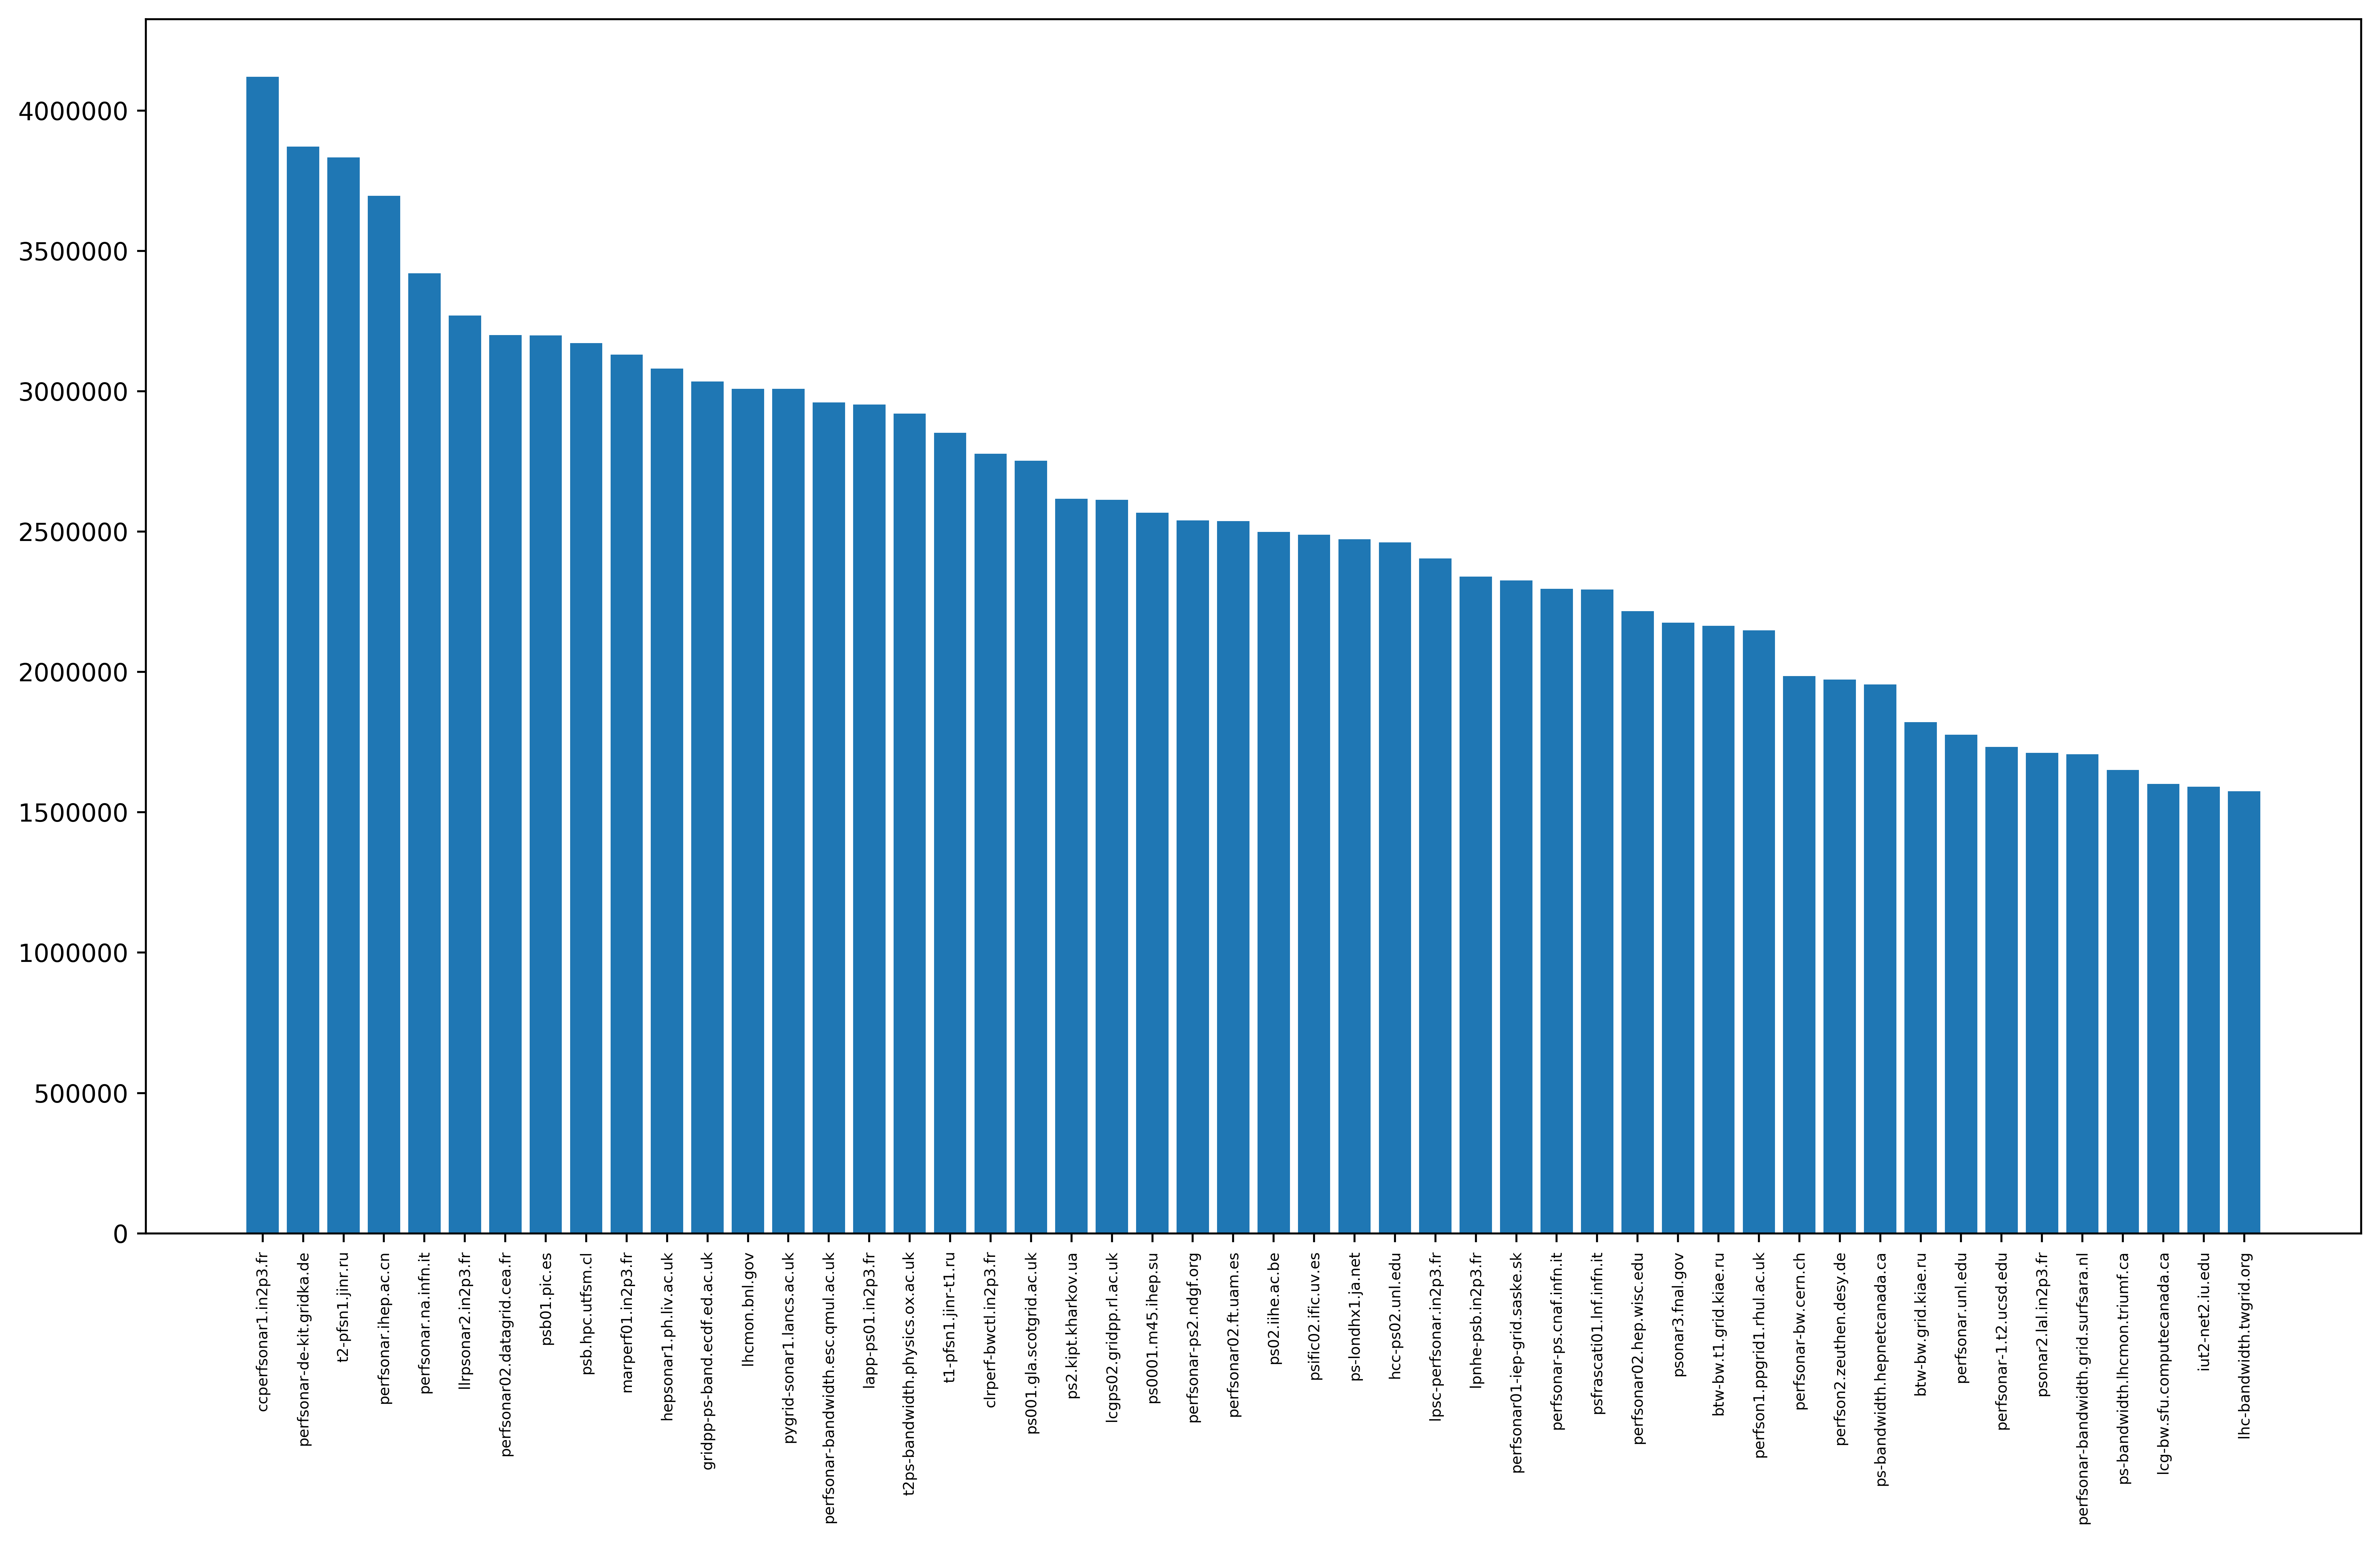

In [83]:
plotByHist(src_data,50)

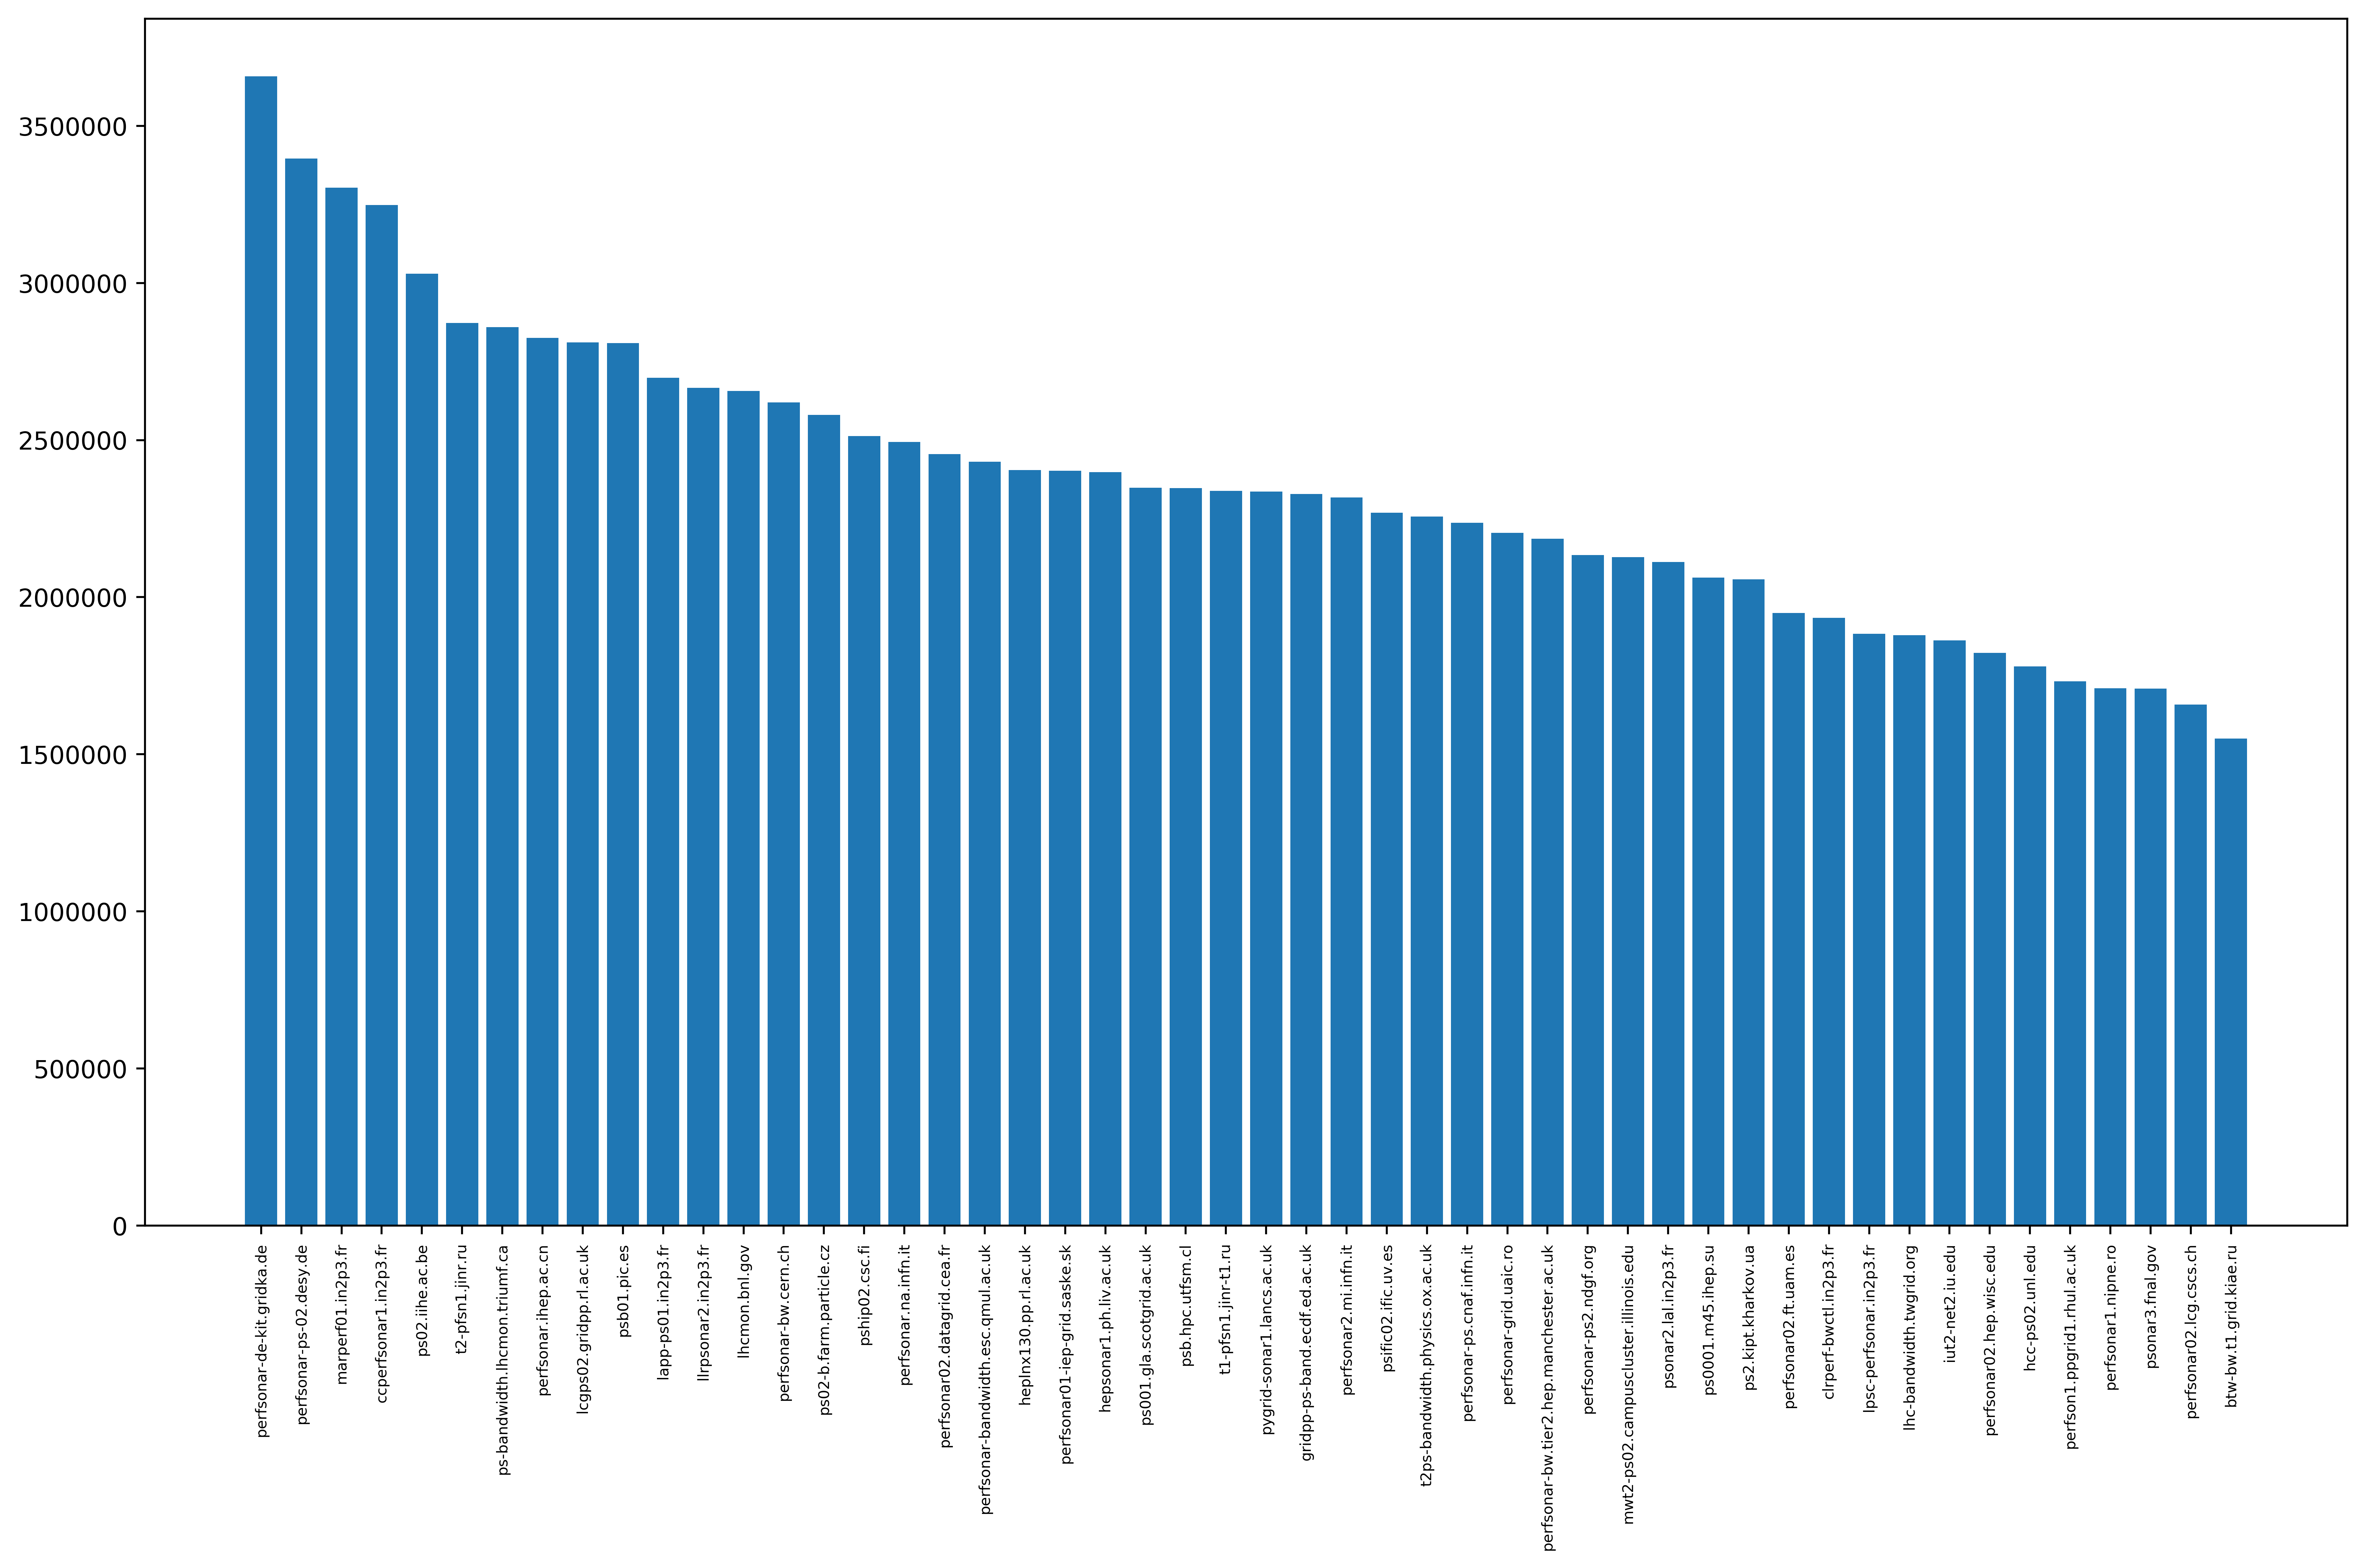

In [84]:
plotByHist(dest_data, 50)

`June 21-24, 2019`

In [85]:
def getNumHashesBetweenHostsInTimeRange(es, index, time_from, time_to):
    '''
    es: Elastic Search connection object
    index: Index to be searched/scanned within
    Time Range
    Time Format: YYYYMMDD'T'HHMMSS'Z' (strings)
    '''
    
    pre_query = {
    "query": {
      "range": {
        "timestamp": {
          "gte": time_from,
          "lte": time_to
        }
      }
    }, 
    "size":0,
    "aggs":{
        
        "uniq_val":{
            "cardinality":{
                    "script":{
                      "source": "doc['src_host'].value + ',' + doc['dest_host'].value",
                      "lang": "painless"
                    }
                }
            }
        }    
    }

    pre_result = es.search(index, body = pre_query)
    sz = pre_result['aggregations']['uniq_val']['value']
    print("Number of Buckets: ",sz)
    
    query = {
    "size": 0, 
    "query": {
      "range": {
        "timestamp": {
          "gte": time_from,
          "lte": time_to
        }
      }
    },
    "aggs":{
        "uniq_val":{
            "terms":{
                    "script":{
                      "source": "doc['src_host'].value + ',' + doc['dest_host'].value",
                      "lang": "painless"
                    },
                "size":sz,
                },
            "aggs":{
                "uniq_hash":{
                    "cardinality":{
                        "field":"hash"
                    }
                }
            }
          }
        }    
    }
    
    X = es.search(index, body=query, request_timeout=30)
    
    return X 
        
    

In [86]:
uniqHashPairs = getNumHashesBetweenHostsInTimeRange(es,'ps_trace','20190515T000000Z','20190601T000000Z')

Number of Buckets:  6023


`June 24, 2019`

In [89]:
pair_data = {'Source':[], 'Destination':[], "NumPaths":[]}
for pair in uniqHashPairs['aggregations']['uniq_val']['buckets']: 
    srcdest = pair['key'].split(",")
    pair_data['Source'].append(srcdest[0])
    pair_data['Destination'].append(srcdest[1])
    pair_data['NumPaths'].append(pair['uniq_hash']['value'])

In [90]:
src_dest_df = pd.DataFrame(pair_data)

In [91]:
src_dest_df.head()

,Source,Destination,NumPaths
0,ps-londhx1.ja.net,ps-slough-10g.ja.net,14
1,perfsonar-bw.cern.ch,ps-bandwidth.lhcmon.triumf.ca,253
2,ps-londhx1.ja.net,bwctl-10g-ps.singaren.net.sg,11
3,ps-londhx1.ja.net,perfsonar.rcs.ic.ac.uk,21
4,perfsonar-bw.cern.ch,2001:67c:1bdc:100::133,106


In [92]:
src_dest_df['NumPaths'].mean(), src_dest_df['NumPaths'].var()

(33.32756036636137, 14475.217636368983)

In [93]:
src_dest_df.sort_values(by=['NumPaths'], ascending=False)

,Source,Destination,NumPaths
360,2620:6a:0:8420::44,ps02-b.farm.particle.cz,2188
2981,2001:660:302c:23:134:158:132:201,wal-perfsonar.msi.umn.edu,1804
461,psonartest1.fnal.gov,pship02.csc.fi,1708
3081,2001:660:302c:23:134:158:132:201,svc-idsdb1.net.usf.edu,1618
3056,2001:660:302c:23:134:158:132:201,perf-scidmz-data.cac.washington.edu,1585
3045,perfsonar-lt.sprace.org.br,2001:660:302c:23:134:158:132:201,1561
2282,perf-scidmz-data.cac.washington.edu,2001:660:302c:23:134:158:132:201,1548
3033,perfsonar-bw.sprace.org.br,2001:660:302c:23:134:158:132:201,1530
2958,2001:660:302c:23:134:158:132:201,2001:12d0:8120::136,1468
2977,2001:660:302c:23:134:158:132:201,sampaps02.if.usp.br,1449


`June 25,26, 2019`

In [94]:
def getDateFormat(delta = 0):
    '''
    Returns the current date and time in the format required for Datetime. 
    delta : the days before the current date, you want the date
    '''
    return str(datetime.now() - timedelta(days = delta )).replace("-","")[:-7].replace(":","").replace(" ","T") + "Z"
    

In [182]:
def getDailyUniquePaths(es, index, src, dest, since):
    """
    Get number of unique paths from 
    src : Source (String)
    dest: Destination (String) 
    since: how many past days
    """
    toDate = getDateFormat(1)
    fromDate = getDateFormat(since)
    
    query = {
      "size": 0,
      "query": {
        "bool": {
          "must": [
            {
              "range": {
                "timestamp": {
                  "gte": fromDate,
                  "lte": toDate
                }
              }
            },
            {
              "term": {
                "src_host": {
                  "value": src
                }
              }
            },
            {
              "term": {
                "dest_host": {
                  "value": dest
                }
              }
            }
          ]
        }
      },
      "aggs": {
        "time_hist": {
          "date_histogram": {
            "field": "timestamp",
            "interval": "day"
          },
          "aggs": {
            "uniq_hash": {
              "cardinality": {
                "field": "hash"
              }
            }
          }
        }
      }
    }
    
    return es.search(index, body=query, request_timeout=30)  

perfsonar-bandwidth.esc.qmul.ac.uk psnr-farm04.slac.stanford.edu
ps2.kipt.kharkov.ua perfsonar02.hep.wisc.edu
sampaps02.if.usp.br perfsonar1.nipne.ro
perfsonar1.nipne.ro lpnhe-psb.in2p3.fr
clrperf-bwctl.in2p3.fr ps001.gla.scotgrid.ac.uk
128.114.109.76 138.23.104.8
ccperfsonar1.in2p3.fr perfsonar02.lcg.cscs.ch


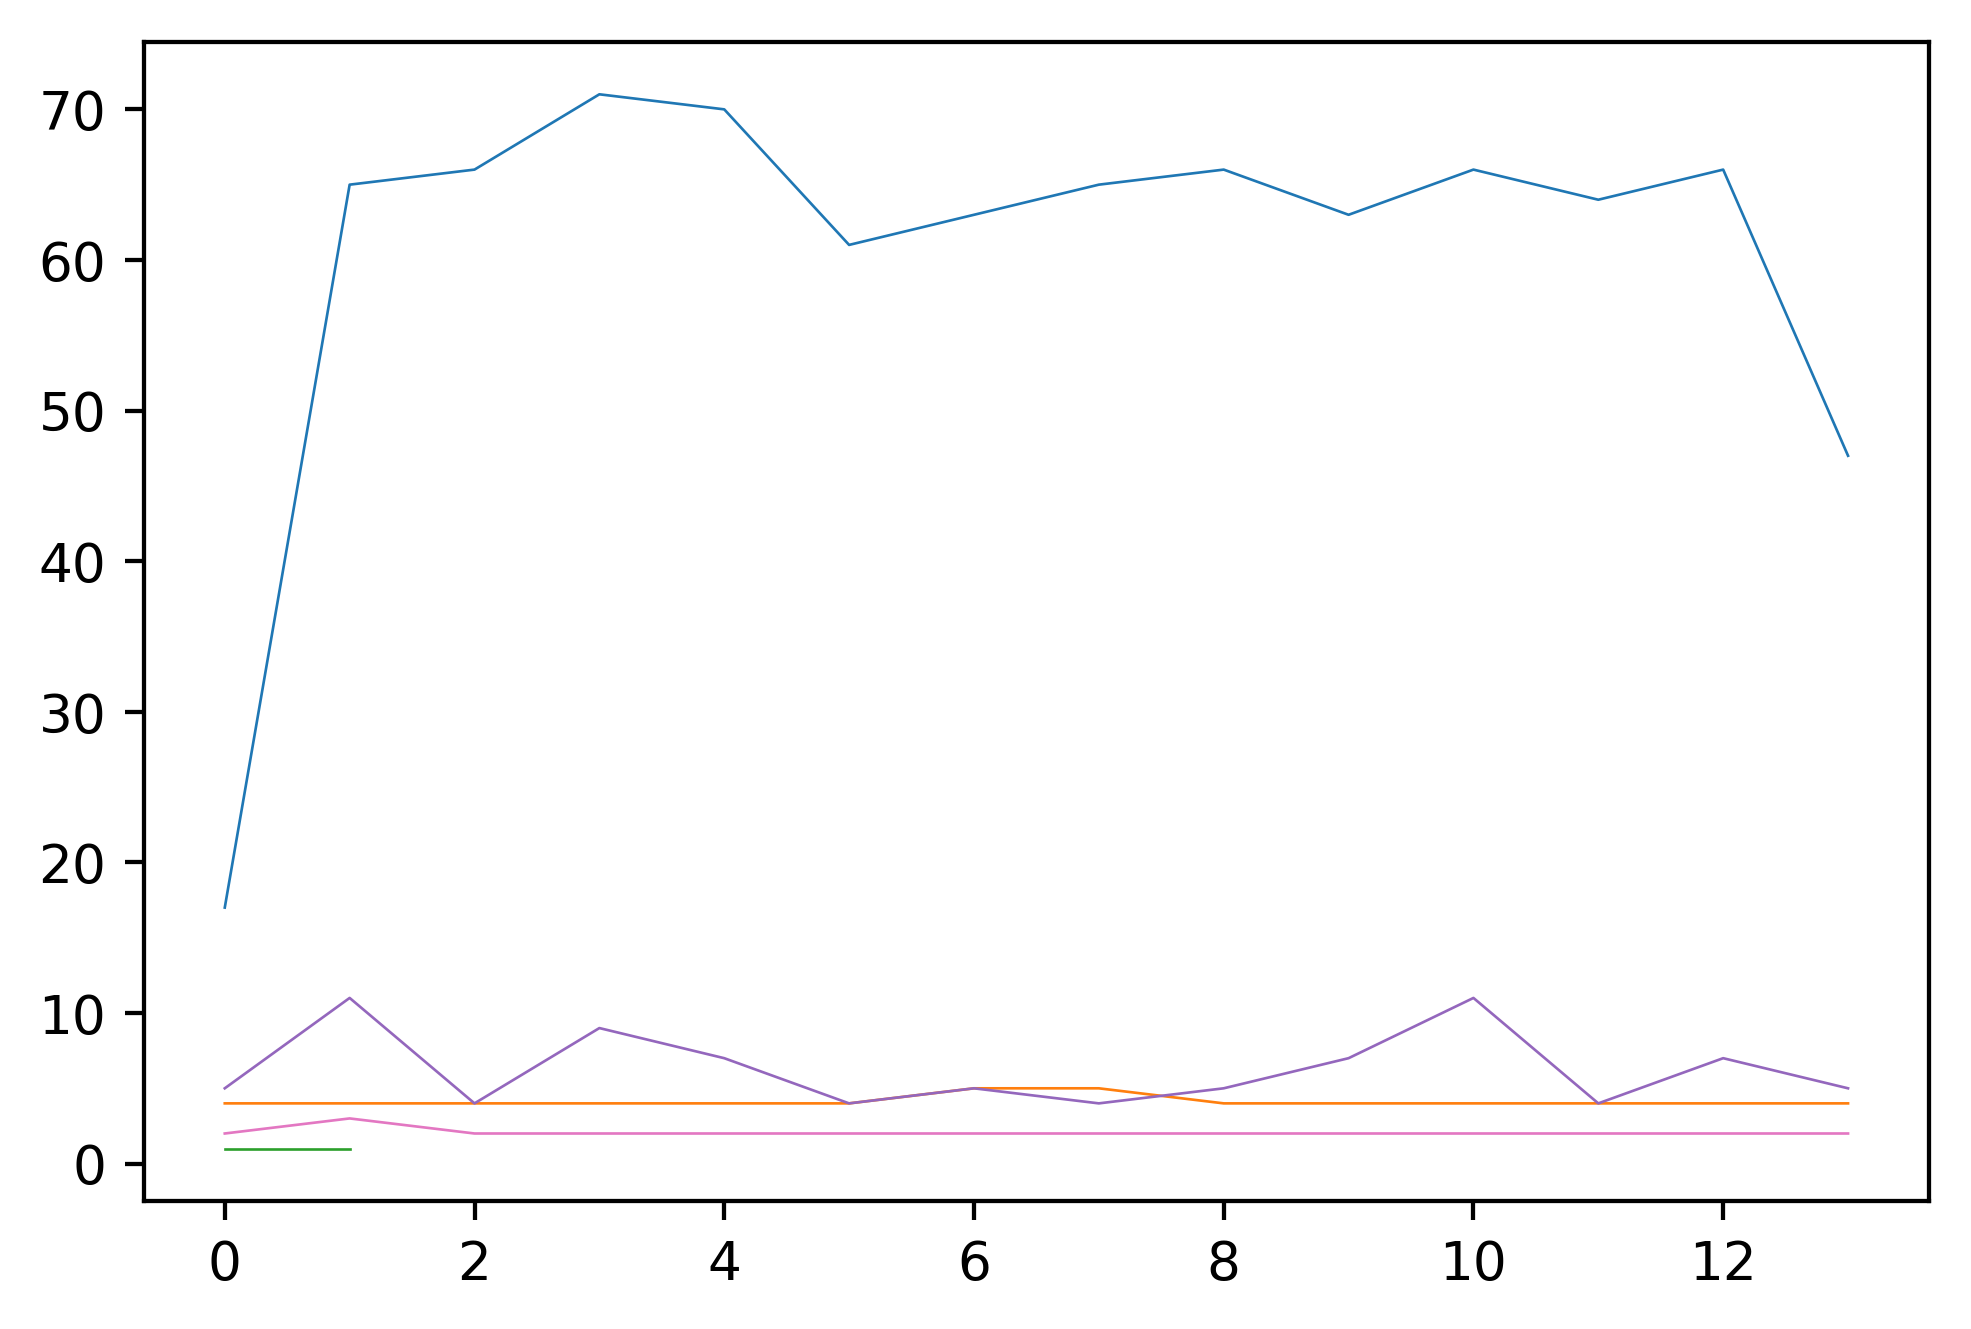

In [189]:
n_samples = 7
smpls = src_dest_df.sample(n=n_samples)
results = [[] for i in range(n_samples)]
j = 0
n_days = 14
plt.figure(dpi=384)
for i,r in smpls.iterrows():
    print(r.Source, r.Destination)
    days = getDailyUniquePaths(es, 'ps_trace', r.Source, r.Destination,n_days)
    for day in days['aggregations']['time_hist']['buckets']:
        results[j].append(day['uniq_hash']['value'])
    plt.plot(results[j], linewidth=0.5, label = r.Source + " > " + r.Destination)
    j += 1

# plt.legend()